**Author:** Boris Kundu

**Problem Statement:** Comparison of CNN techniques

**Dataset:** COVID-19 hospitalizations

In [210]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
%matplotlib inline

In [211]:
data = np.genfromtxt('hospitalizations.txt', delimiter=' ')
hosp = data[:,1]
mean = np.mean(hosp, axis=0)
std = np.std(hosp, axis=0)
hosp = (hosp - mean)/std

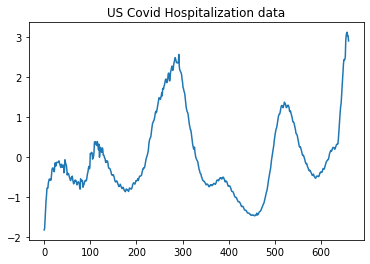

In [212]:
plt.plot(hosp)
plt.title('US Covid Hospitalization data')
plt.show()

In [213]:
last = len(hosp)
seqlen = 20 # input size or window size
batchsize = 50 # data period and number of data points
trainbegin = np.random.randint(400)

In [214]:
Xtrain = hosp[trainbegin:trainbegin+seqlen]
ytrain = hosp[trainbegin+seqlen]
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [215]:
#Linear Regression
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
ypred = lin_reg.predict(Xtrain)
print('LinearRegression MSE:', mean_squared_error(ytrain, ypred))

LinearRegression MSE: 0.004543808159387797


In [216]:
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)
print(f'X Shape:{X.shape}')
print(f'Y Shape:{y.shape}')

X Shape:torch.Size([50, 20])
Y Shape:torch.Size([50])


In [217]:
#For GRUCell
inputsize = 1
hiddensize = 10
outputsize = 1
iterations = 1000
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [218]:
class GRUCell(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, seqlen, batchsize):
        super(GRUCell, self).__init__()
        self.rnn = nn.GRUCell(inputsize, hiddensize)
        self.layer2 = nn.Linear(hiddensize, outputsize)
    def forward(self, x):
        hx = torch.randn(batchsize, hiddensize)
        for i in range(seqlen):
            hx = self.rnn(X2[i], hx)
        return self.layer2(hx)[:, 0]

In [219]:
model = GRUCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [220]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

Epoch:1 with Loss:3.4735889434814453
Epoch:101 with Loss:0.3818792700767517
Epoch:201 with Loss:0.05484144389629364
Epoch:301 with Loss:0.0503804050385952
Epoch:401 with Loss:0.04461286962032318
Epoch:501 with Loss:0.037253525108098984
Epoch:601 with Loss:0.027923867106437683
Epoch:701 with Loss:0.016984475776553154
Epoch:801 with Loss:0.014358137734234333
Epoch:901 with Loss:0.012922792695462704


In [221]:
yGRU = yhat
print('GRU MSE:', F.mse_loss(yhat, y).item())

GRU MSE: 0.011737953871488571


In [222]:
kernelsize = 3
stride = 2
X2 = torch.reshape(X, (batchsize, inputsize, seqlen))

In [223]:
class Model(nn.Module):
    def __init__(self, inputsize, hiddensize, outputsize, kernelsize, stride, batchsize):
        super(Model, self).__init__()
        self.cnn1 = nn.Conv1d(inputsize, hiddensize, kernelsize, stride=stride)
        self.activation = nn.ReLU()
        self.pool = nn.AvgPool1d(kernelsize)
        self.cnn2 = nn.Conv1d(hiddensize, outputsize, kernelsize)

    def forward(self, x):
        activated = self.activation(self.cnn1(x))
        pooled = self.pool(activated)
        output = self.cnn2(pooled)
        return output[:, 0, 0]

In [224]:
model = Model(inputsize, hiddensize, outputsize, kernelsize, stride, batchsize)
optimizer = optim.Adam(model.parameters())

In [225]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

Epoch:1 with Loss:8.462798118591309
Epoch:101 with Loss:0.8398215770721436
Epoch:201 with Loss:0.044041022658348083
Epoch:301 with Loss:0.04344680905342102
Epoch:401 with Loss:0.04281901195645332
Epoch:501 with Loss:0.042141176760196686
Epoch:601 with Loss:0.041435226798057556
Epoch:701 with Loss:0.040719173848629
Epoch:801 with Loss:0.04000772535800934
Epoch:901 with Loss:0.03931061923503876


In [226]:
yCNN = yhat
print('CNN MSE:', F.mse_loss(yhat, y).item())

CNN MSE: 0.03864123299717903


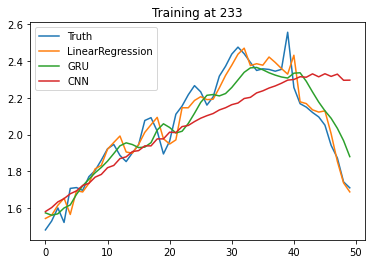

In [227]:
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yCNN.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRU', 'CNN'])
plt.title('Training at ' + str(trainbegin))
plt.show()

In [228]:
seqlen = 28 # input size or window size

In [229]:
Xtrain = hosp[trainbegin:trainbegin+seqlen]
ytrain = hosp[trainbegin+seqlen]
for i in range(1, batchsize):
    Xtrain = np.vstack([Xtrain, hosp[trainbegin+i:trainbegin+i+seqlen]])
    ytrain = np.append(ytrain, hosp[trainbegin+i+seqlen])

In [230]:
#Linear regression on Conv1d with different sqlen and params
lin_reg = LinearRegression()
lin_reg.fit(Xtrain, ytrain)
ypred = lin_reg.predict(Xtrain)
print('LinearRegression MSE:', mean_squared_error(ytrain, ypred))

LinearRegression MSE: 0.0032672021529352056


In [231]:
X = torch.tensor(Xtrain, dtype=torch.float)
y = torch.tensor(ytrain, dtype=torch.float)
print(f'X Shape:{X.shape}')
print(f'Y Shape:{y.shape}')

X Shape:torch.Size([50, 28])
Y Shape:torch.Size([50])


In [232]:
#For GRU Cell
inputsize = 1
hiddensize = 10
outputsize = 1
X2 = torch.reshape(X.T, (seqlen, batchsize, inputsize))

In [233]:
model = GRUCell(inputsize, hiddensize, outputsize, seqlen, batchsize)
optimizer = optim.Adam(model.parameters())

In [234]:
for i in range(iterations):
    yhat = model(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'Epoch:{i+1} with Loss:{L.item()}')
    optimizer.zero_grad()
    L.backward()
    optimizer.step()

Epoch:1 with Loss:2.68227481842041
Epoch:101 with Loss:0.3852275013923645
Epoch:201 with Loss:0.10317128151655197
Epoch:301 with Loss:0.09398709237575531
Epoch:401 with Loss:0.0815044417977333
Epoch:501 with Loss:0.06334556639194489
Epoch:601 with Loss:0.04168884456157684
Epoch:701 with Loss:0.01736360788345337
Epoch:801 with Loss:0.010410887189209461
Epoch:901 with Loss:0.009238493628799915


In [235]:
yGRU = yhat
print('GRU MSE:', F.mse_loss(yhat, y).item())

GRU MSE: 0.008480801247060299


In [236]:
hiddensize1 = 6
hiddensize2 = 16
hiddensize3 = 80
hiddensize4 = 20
kernelsize = 5
poolsize = 2
X2 = torch.reshape(X, (batchsize, inputsize, seqlen))

In [237]:
class Model1(nn.Module):
    def __init__(self, inputsize, hiddensize1, hiddensize2, hiddensize3, hiddensize4, outputsize, kernelsize, poolsize, batchsize):
        super(Model1, self).__init__()
        self.cnn1 = nn.Conv1d(inputsize, hiddensize1, kernelsize, padding=2)
        self.pool1 = nn.AvgPool1d(poolsize)
        self.cnn2 = nn.Conv1d(hiddensize1, hiddensize2, kernelsize)
        self.pool2 = nn.AvgPool1d(poolsize)
        self.linear1 = nn.Linear(hiddensize3, hiddensize4)
        self.linear2 = nn.Linear(hiddensize4, outputsize)

    def forward(self, x):
        conved1 = self.cnn1(x)
        pooled1 = self.pool1(conved1)
        conved2 = self.cnn2(pooled1)
        pooled2 = self.pool2(conved2)
        x = pooled2.reshape(batchsize, hiddensize3)
        z = self.linear1(x)
        output = self.linear2(z)
        return output[:, 0]

In [238]:
model1 = Model1(inputsize, hiddensize1, hiddensize2, hiddensize3, hiddensize4, 
            outputsize, kernelsize, poolsize, batchsize)
optimizer1 = optim.Adam(model1.parameters())

In [239]:
for i in range(epochs):
    yhat = model1(X2)
    L = F.mse_loss(yhat, y)
    if(i%100 == 0):
        print(f'Epoch:{i+1} with Loss:{L.item()}')
    optimizer1.zero_grad()
    L.backward()
    optimizer1.step()

Epoch:1 with Loss:4.072117328643799
Epoch:101 with Loss:0.12621378898620605
Epoch:201 with Loss:0.016778239980340004
Epoch:301 with Loss:0.013548013754189014
Epoch:401 with Loss:0.01259706262499094
Epoch:501 with Loss:0.011670383624732494
Epoch:601 with Loss:0.010787134990096092
Epoch:701 with Loss:0.009964220225811005
Epoch:801 with Loss:0.00921714585274458
Epoch:901 with Loss:0.008558540605008602


In [240]:
yCNN = yhat
print('LeNet5 MSE:', F.mse_loss(yhat, y).item())

LeNet5 MSE: 0.008000866509974003


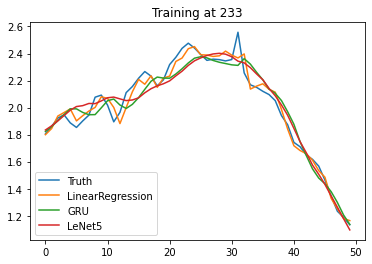

In [241]:
plt.plot(ytrain)
plt.plot(ypred)
plt.plot(yGRU.detach().numpy())
plt.plot(yCNN.detach().numpy())
plt.legend(['Truth','LinearRegression', 'GRU', 'LeNet5'])
plt.title('Training at ' + str(trainbegin))
plt.show()